In [1]:
!pip install torchdiffeq

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import StepLR
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Взяты отсюда https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/

In [29]:
data_main = pd.read_csv('AEP_hourly.csv')
data = data_main[:4000]
data_numeric = data.iloc[:, 1:]

In [33]:
train_size = int(len(data_numeric) * 0.8)
test_size = len(data_numeric) - train_size
train, test = data_numeric[:train_size], data_numeric[train_size:]

In [34]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train)
scaled_test_data = scaler.fit_transform(test)

class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback):
        self.data = data
        self.lookback = lookback

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.lookback]
        y = self.data[idx+self.lookback]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

#LSTM

In [175]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# Параметры
input_size = 1
hidden_size = 50
output_size = 1
lookback = 24
batch_size = 24 # выбраны одинаковые размерности с lookback, чтобы совпадали размерности при оценивании модели
num_epochs = 40

# DataLoader
dataset_train = TimeSeriesDataset(scaled_train_data, lookback)
dataset_test = TimeSeriesDataset(scaled_test_data, lookback)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size)

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()

In [176]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_mae = []
test_mse = []
test_r2 = []

def test_model(model):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        predictions = []
        actuals = []
        len_loader = len(test_loader)
        for X, y in test_loader:
            len_loader -= 1
            if len_loader == 0: break
            outputs = model(X)
            loss = criterion(outputs.squeeze(), y)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(y.tolist())

        mae = mean_absolute_error(actuals, predictions)
        mse = mean_squared_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        return mae, mse, r2

In [177]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses_lstm = []
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs.squeeze(), y)
        loss.backward()
        optimizer.step()
    losses_lstm.append(loss.detach().numpy())
    print('epoch {} loss {}'.format(epoch, loss))
    mae, mse, r2 = test_model(model)
    test_mae.append(mae)
    test_mse.append(mse)
    test_r2.append(r2)


epoch 0 loss 0.04282344877719879
epoch 1 loss 0.02990594319999218
epoch 2 loss 0.03680340573191643
epoch 3 loss 0.024688825011253357
epoch 4 loss 0.032183434814214706
epoch 5 loss 0.034631770104169846
epoch 6 loss 0.04993121325969696
epoch 7 loss 0.03778814151883125
epoch 8 loss 0.014831095933914185
epoch 9 loss 0.02231321670114994
epoch 10 loss 0.078030526638031
epoch 11 loss 0.02544476091861725
epoch 12 loss 0.05252255126833916
epoch 13 loss 0.046233296394348145
epoch 14 loss 0.04319179058074951
epoch 15 loss 0.03571728989481926
epoch 16 loss 0.022295555099844933
epoch 17 loss 0.015848396345973015
epoch 18 loss 0.022670596837997437
epoch 19 loss 0.04571032524108887
epoch 20 loss 0.006558045744895935
epoch 21 loss 0.022971482947468758
epoch 22 loss 0.044018443673849106
epoch 23 loss 0.05509856715798378
epoch 24 loss 0.031469330191612244
epoch 25 loss 0.030014580115675926
epoch 26 loss 0.027757855132222176
epoch 27 loss 0.030321598052978516
epoch 28 loss 0.024072865024209023
epoch 29 l

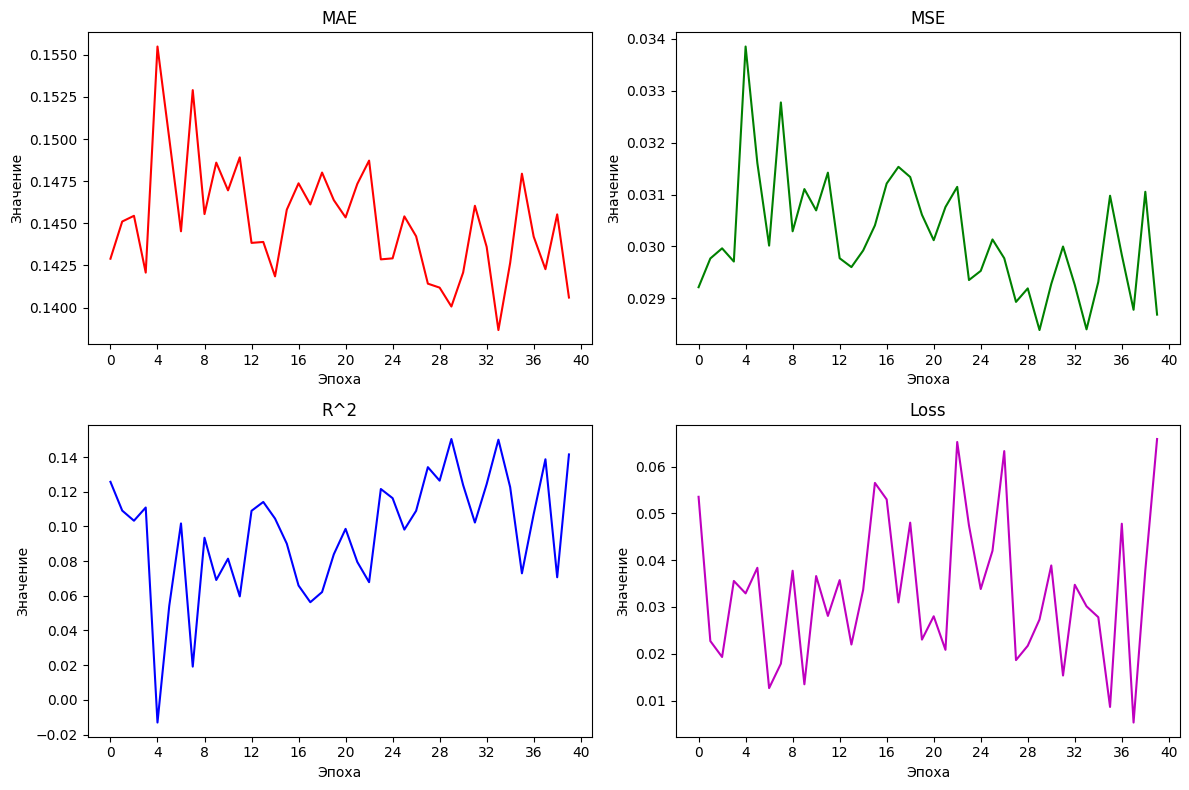

In [70]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Графики для test_mae
axs[0, 0].plot(test_mae, color='r')
axs[0, 0].set_title('MAE')
axs[0, 0].set_xlabel('Эпоха')
axs[0, 0].set_ylabel('Значение')
axs[0, 0].xaxis.set_major_locator(plt.MultipleLocator(4))

# Графики для test_mse
axs[0, 1].plot(test_mse, color='g')
axs[0, 1].set_title('MSE')
axs[0, 1].set_xlabel('Эпоха')
axs[0, 1].set_ylabel('Значение')
axs[0, 1].xaxis.set_major_locator(plt.MultipleLocator(4))

# Графики для test_r2
axs[1, 0].plot(test_r2, color='b')
axs[1, 0].set_title('R^2')
axs[1, 0].set_xlabel('Эпоха')
axs[1, 0].set_ylabel('Значение')
axs[1, 0].xaxis.set_major_locator(plt.MultipleLocator(4))

# Графики для test_loss
axs[1, 1].plot(losses_lstm, color='m')
axs[1, 1].set_title('Loss')
axs[1, 1].set_xlabel('Эпоха')
axs[1, 1].set_ylabel('Значение')
axs[1, 1].xaxis.set_major_locator(plt.MultipleLocator(4))

plt.tight_layout()
plt.show()

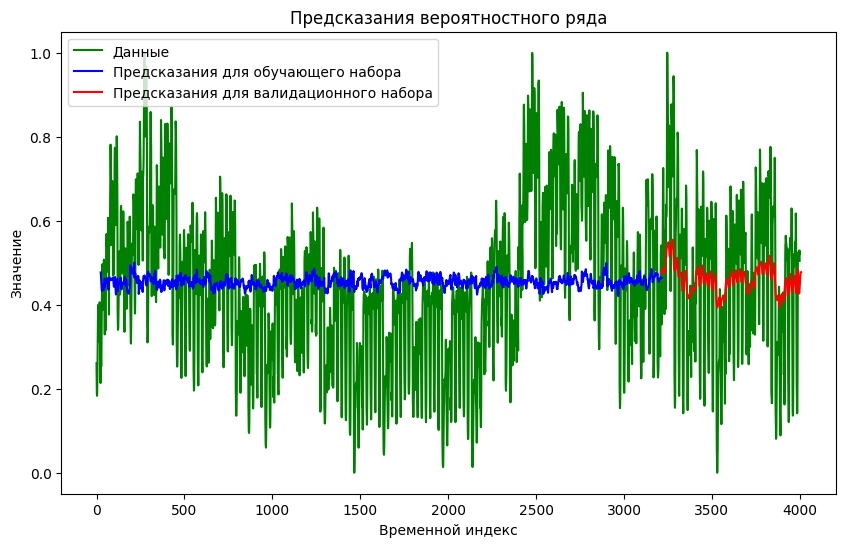

In [71]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    predicted_train_data = []
    for X, _ in train_loader:
        predicted_train_data.append(model(X))
    predicted_train_data = torch.cat(predicted_train_data)

    predicted_test_data = []
    for X, _ in test_loader:
        predicted_test_data.append(model(X))
    predicted_test_data = torch.cat(predicted_test_data)

all_data = np.concatenate([scaled_train_data, scaled_test_data])

# Визуализация предсказаний и реальных данных
plt.figure(figsize=(10, 6))
plt.plot(all_data, label='Данные', color='g')
plt.plot(range(lookback, lookback + len(predicted_train_data)), predicted_train_data, label='Предсказания для обучающего набора', color='b')
plt.plot(range(lookback + len(predicted_train_data), lookback + len(predicted_train_data) + len(predicted_test_data)), predicted_test_data, label='Предсказания для валидационного набора', color='r')
plt.title('Предсказания вероятностного ряда')
plt.xlabel('Временной индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

#ODENet

In [153]:
class ODENet(nn.Module):
    def __init__(self):
        super(ODENet, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, t, x):
        x = torch.sin(self.fc1(x))
        x = self.fc2(x)
        return x



ode_net = ODENet()
optimizer = optim.Adam(ode_net.parameters(), lr=0.005)
criterion = nn.MSELoss()

def ode_func(t, y):
    return ode_net(t, y)

def test_model_ode(model):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        predictions = []
        actuals = []
        len_loader = len(test_loader)
        for X, y in test_loader:
            len_loader -= 1
            if len_loader == 0: break
            outputs = odeint(ode_func, X, torch.arange(len(X)).float())
            loss = criterion(outputs.squeeze(), y)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(y.tolist())
        pred = torch.FloatTensor(predictions)
        mae = mean_absolute_error(actuals, pred[:, 0, 0])
        mse = mean_squared_error(actuals, pred[:, 0, 0])
        r2 = r2_score(actuals, pred[:, 0, 0] )
        return mae, mse, r2

test_mae_ode = []
test_mse_ode = []
test_r2_ode = []
test_mape_ode = []
test_loss_ode = []

ode_net = ODENet()
optimizer = optim.Adam(ode_net.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(ode_net.parameters(), lr=0.001)

losses_ode = []

# Обучение модели
for epoch in range(num_epochs): #num_epochs
    ode_net.train()
    len_loader = len(train_loader)
    for X, y in train_loader:
        len_loader -= 1
        if len_loader == 0: break
        optimizer.zero_grad()
        preds = odeint(ode_func, X, torch.arange(len(X)).float())
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

    losses_ode.append(loss.detach().numpy())
    print('epoch {} loss {}'.format(epoch, loss))
    mae, mse, r2 = test_model_ode(ode_net)
    test_mae_ode.append(mae)
    test_mse_ode.append(mse)
    test_r2_ode.append(r2)

In [160]:
losses_ode2 = []
for i in losses_ode:
    losses_ode2.append(i.detach().numpy())

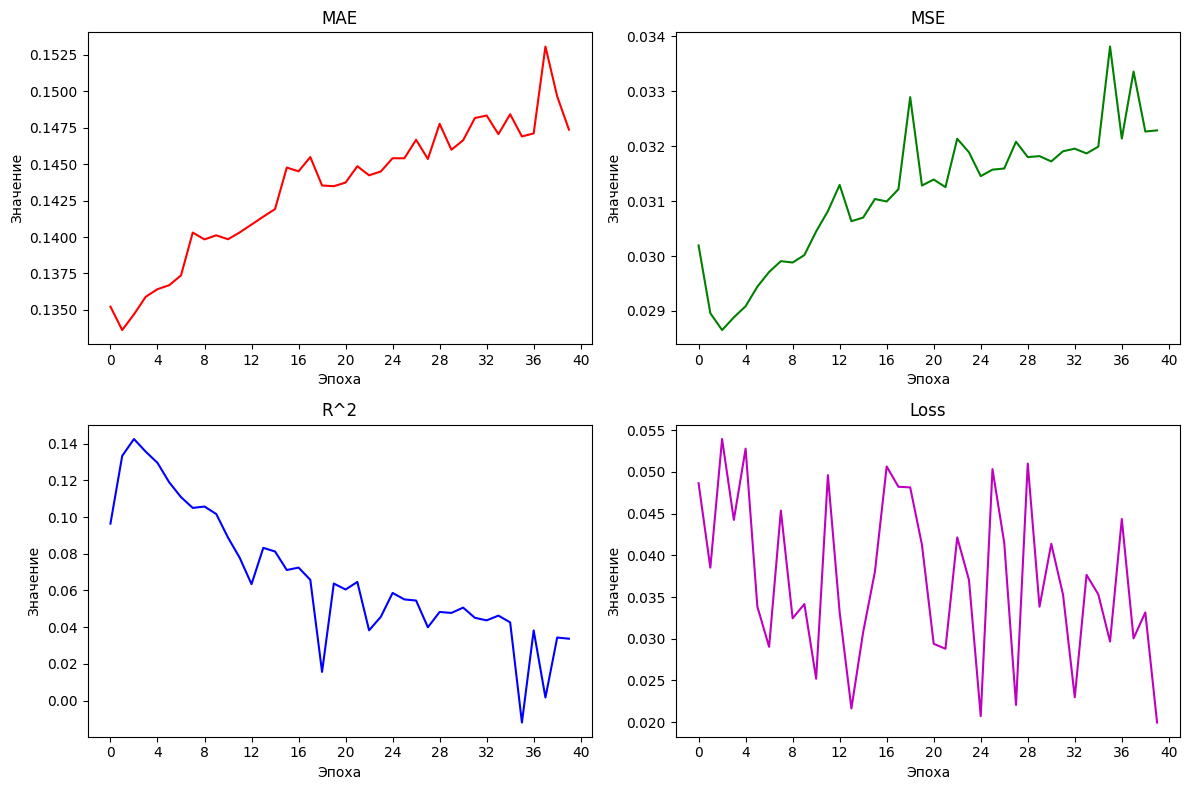

In [161]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Графики для test_mae
axs[0, 0].plot(test_mae_ode, color='r')
axs[0, 0].set_title('MAE')
axs[0, 0].set_xlabel('Эпоха')
axs[0, 0].set_ylabel('Значение')
axs[0, 0].xaxis.set_major_locator(plt.MultipleLocator(4))

# Графики для test_mse
axs[0, 1].plot(test_mse_ode, color='g')
axs[0, 1].set_title('MSE')
axs[0, 1].set_xlabel('Эпоха')
axs[0, 1].set_ylabel('Значение')
axs[0, 1].xaxis.set_major_locator(plt.MultipleLocator(4))

# Графики для test_r2
axs[1, 0].plot(test_r2_ode, color='b')
axs[1, 0].set_title('R^2')
axs[1, 0].set_xlabel('Эпоха')
axs[1, 0].set_ylabel('Значение')
axs[1, 0].xaxis.set_major_locator(plt.MultipleLocator(4))

# Графики для test_loss
axs[1, 1].plot(losses_ode2, color='m')
axs[1, 1].set_title('Loss')
axs[1, 1].set_xlabel('Эпоха')
axs[1, 1].set_ylabel('Значение')
axs[1, 1].xaxis.set_major_locator(plt.MultipleLocator(4))

plt.tight_layout()
plt.show()

In [155]:
ode_net.eval()
with torch.no_grad():
    predicted_train_data = []
    len_loader = len(train_loader)
    for X, _ in train_loader:
        len_loader -= 1
        if len_loader == 0: break
        predicted_train_data.append(odeint(ode_func, X, torch.arange(len(X)).float()))
    predicted_train_data = torch.cat(predicted_train_data)

    predicted_test_data = []
    len_loader = len(test_loader)
    for X, _ in test_loader:
        len_loader -= 1
        if len_loader == 0: break
        predicted_test_data.append(odeint(ode_func, X, torch.arange(len(X)).float()))
    predicted_test_data = torch.cat(predicted_test_data)

all_data = np.concatenate([scaled_train_data, scaled_test_data])


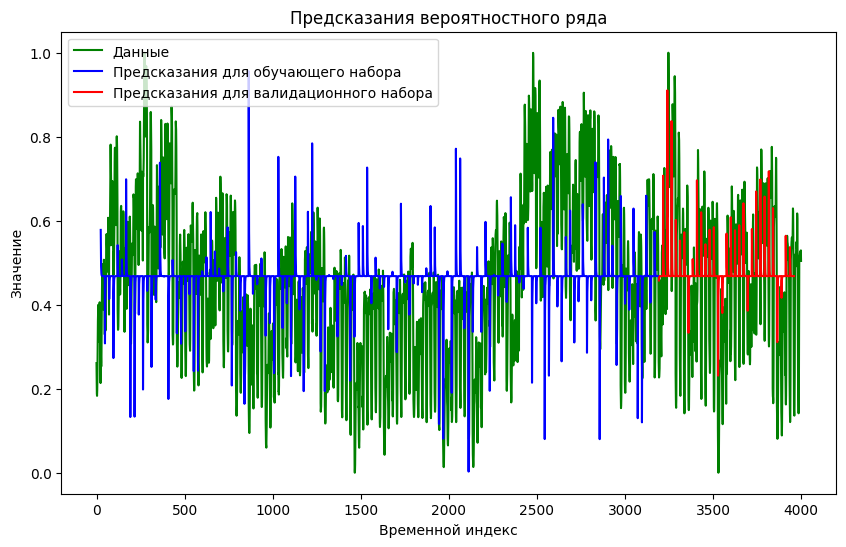

In [156]:
predic_train =  predicted_train_data.numpy()[:, 0, 0]
predic_test = predicted_test_data.numpy()[:, 0, 0]


# Визуализация предсказаний и реальных данных
plt.figure(figsize=(10, 6))
plt.plot(all_data, label='Данные', color='g')
plt.plot(range(lookback, lookback + len(predic_train)), predic_train, label='Предсказания для обучающего набора', color='b')
plt.plot(range(lookback + len(predicted_train_data), lookback + len(predicted_train_data) + len(predicted_test_data)), predic_test, label='Предсказания для валидационного набора', color='r')
plt.title('Предсказания вероятностного ряда')
plt.xlabel('Временной индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

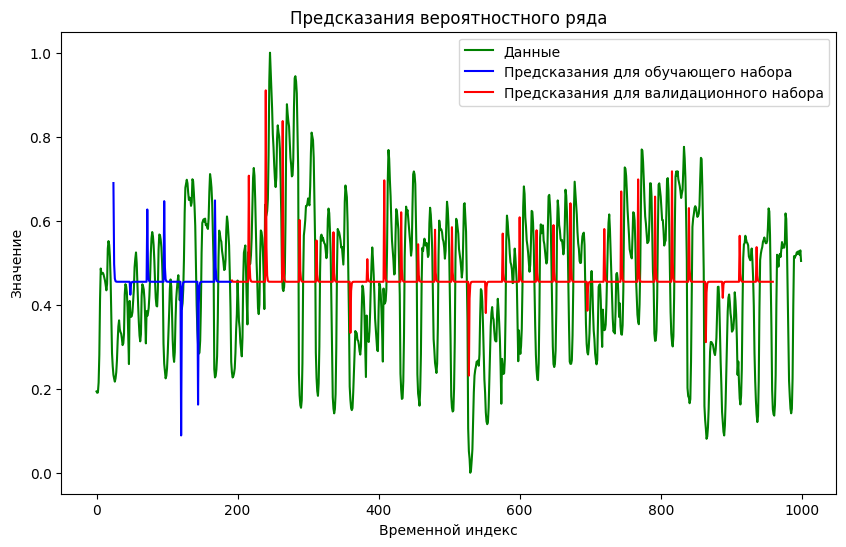

In [121]:
predic_train =  predicted_train_data.numpy()[3000:, 0, 0]
predic_test = predicted_test_data.numpy()[:, 0, 0]


# Визуализация предсказаний и реальных данных
plt.figure(figsize=(10, 6))
plt.plot(all_data[3000:], label='Данные', color='g')
plt.plot(range(lookback, lookback + len(predic_train)), predic_train, label='Предсказания для обучающего набора', color='b')
plt.plot(range(lookback + len(predic_train), lookback + len(predic_train) + len(predic_test)), predic_test, label='Предсказания для валидационного набора', color='r')
plt.title('Предсказания вероятностного ряда')
plt.xlabel('Временной индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

#Сравнение

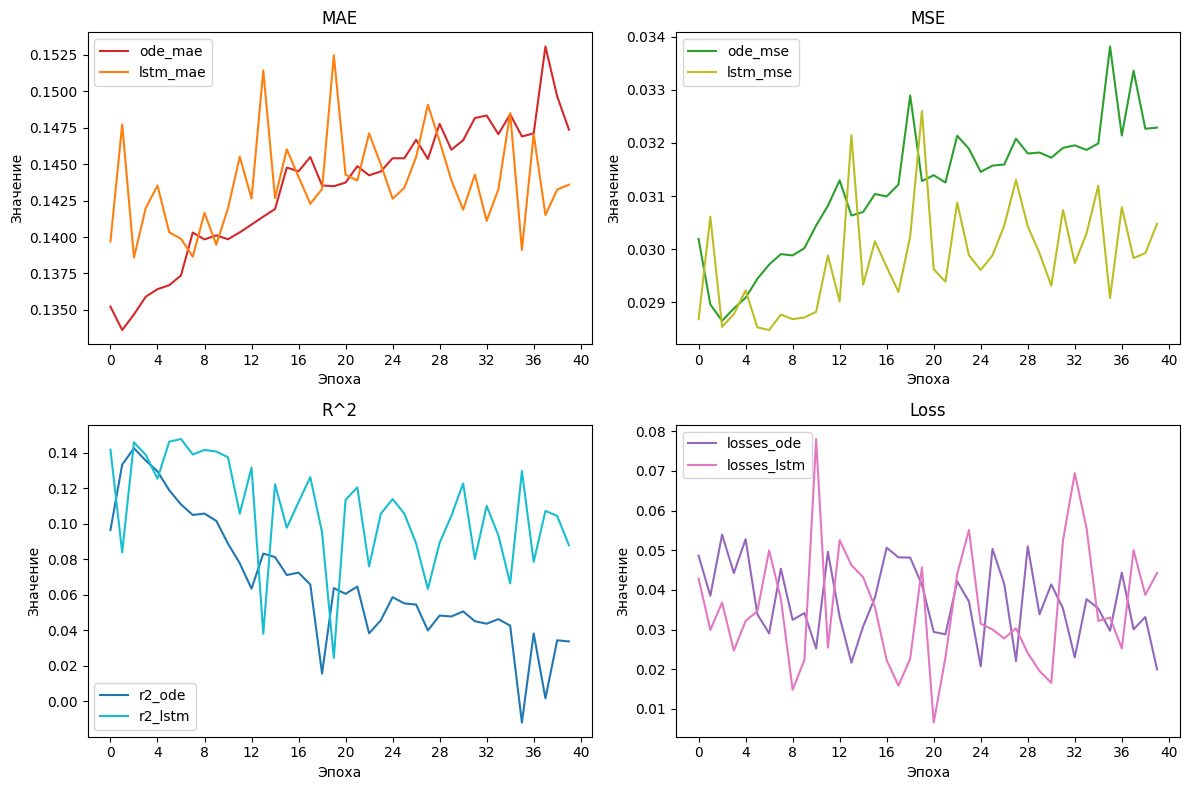

In [185]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Графики для test_mae
axs[0, 0].plot(test_mae_ode, color='tab:red', label='ode_mae')
axs[0, 0].plot(test_mae, color='tab:orange', label='lstm_mae')
axs[0, 0].set_title('MAE')
axs[0, 0].set_xlabel('Эпоха')
axs[0, 0].set_ylabel('Значение')
axs[0, 0].xaxis.set_major_locator(plt.MultipleLocator(4))
axs[0, 0].legend()

# Графики для test_mse
axs[0, 1].plot(test_mse_ode, color='tab:green', label='ode_mse')
axs[0, 1].plot(test_mse, color='tab:olive', label='lstm_mse')
axs[0, 1].set_title('MSE')
axs[0, 1].set_xlabel('Эпоха')
axs[0, 1].set_ylabel('Значение')
axs[0, 1].xaxis.set_major_locator(plt.MultipleLocator(4))
axs[0, 1].legend()

# Графики для test_r2
axs[1, 0].plot(test_r2_ode, color='tab:blue', label='r2_ode')
axs[1, 0].plot(test_r2, color='tab:cyan', label='r2_lstm')  # Добавление графика test_r2
axs[1, 0].set_title('R^2')
axs[1, 0].set_xlabel('Эпоха')
axs[1, 0].set_ylabel('Значение')
axs[1, 0].xaxis.set_major_locator(plt.MultipleLocator(4))
axs[1, 0].legend()

# Графики для losses_lstm
axs[1, 1].plot(losses_ode2, color='tab:purple', label='losses_ode')
axs[1, 1].plot(losses_lstm, color='tab:pink', label='losses_lstm')
axs[1, 1].set_title('Loss')
axs[1, 1].set_xlabel('Эпоха')
axs[1, 1].set_ylabel('Значение')
axs[1, 1].xaxis.set_major_locator(plt.MultipleLocator(4))
axs[1, 1].legend()

plt.tight_layout()
plt.show()



In [178]:
model.eval()
with torch.no_grad():
    predicted_test_data = []
    for X, _ in test_loader:
        predicted_test_data.append(model(X))
    predicted_test_data = torch.cat(predicted_test_data)


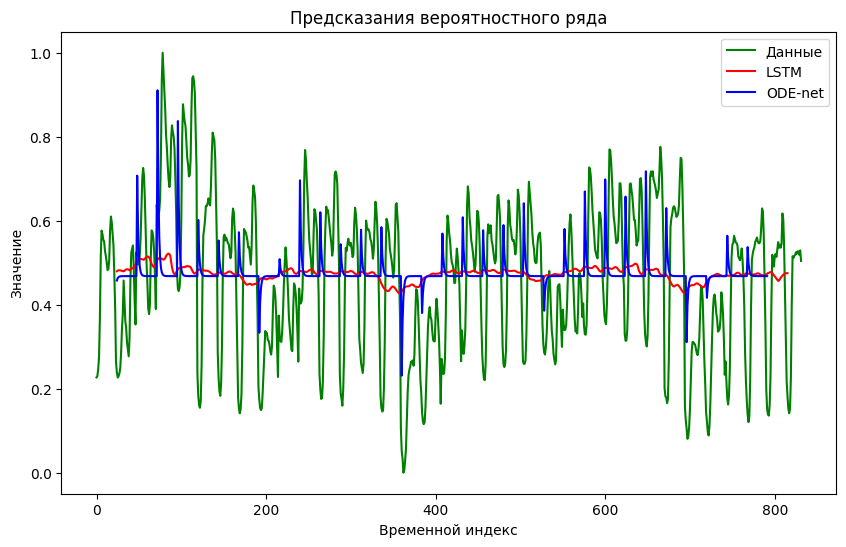

In [184]:
# Визуализация предсказаний и реальных данных
plt.figure(figsize=(10, 6))
plt.plot(all_data[3168:], label='Данные', color='g')
plt.plot(range(lookback, lookback + len(predicted_test_data)), predicted_test_data, label='LSTM', color='r')
plt.plot(range(lookback, lookback + len(predic_test)), predic_test, label='ODE-net', color='blue')
plt.title('Предсказания вероятностного ряда')
plt.xlabel('Временной индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()